In [1]:
!pwd

/external1/nguyenpham/code/Develop_uncertainty/figure_output


In [2]:
import ot
import otdd
import numpy as np
from otdd.pytorch.distance import DatasetDistance
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import pandas as pd
import argparse
import sys
#
torch.cuda.set_device(1)
import math

sys.path.append("/external1/nguyenpham/code/Develop_uncertainty/our_method")
from my_gpytorch import settings
from my_gpytorch import utils
from my_gpytorch.kernels import *
from my_gpytorch.mymodels import *
from uncertainty_framework import uncertainty_framework

/home/nguyenpk/miniconda3/envs/resnet_env/lib/python3.9/site-packages/otdd/pytorch/distance.py:23: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
ot.gpu not found - coupling computation will be in cpu


In [3]:
from my_gpytorch.dataset import *
from my_gpytorch.label_distance import *

In [4]:
from sklearn.datasets import make_moons , make_circles,make_blobs
from sklearn.metrics import pairwise
from sklearn.metrics import classification_report, confusion_matrix, auc, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp




In [5]:
# n_samples = 4000
n_components = 3

X, y_true = make_blobs(
    n_samples=[2000, 1000, 1000], centers=None, cluster_std=0.3, random_state=0
)



idx_party = np.ones_like(y_true)*-1
o0 = y_true == 0
s = o0.sum()
t_mask = np.zeros(s, dtype=bool)
t_mask[np.random.choice(s, int(s/2), replace=False)] = True
o1 = o0.copy()
o1[o1] = t_mask
idx_party[o1] = 0

o2 = o0 & (~o1)
idx_party[o2] = 1

o3 =  y_true == 1
idx_party[o3] = 2
o4 = y_true == 2
idx_party[o4] = 3

# fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 8)) 
cm = ["l", "l'", 'j', "C"]
for i in range(len(cm)):
    x = X[idx_party == i]
    plt.scatter(x[:,0], x[:,1], label=cm[i], alpha=0.3, edgecolors='none')
plt.legend(loc='best')
plt.title("Synthetic Dataset")

# plt.savefig("circle.png", format="png", bbox_inches='tight', dpi=300)

plt.show()

In [6]:
%matplotlib inline

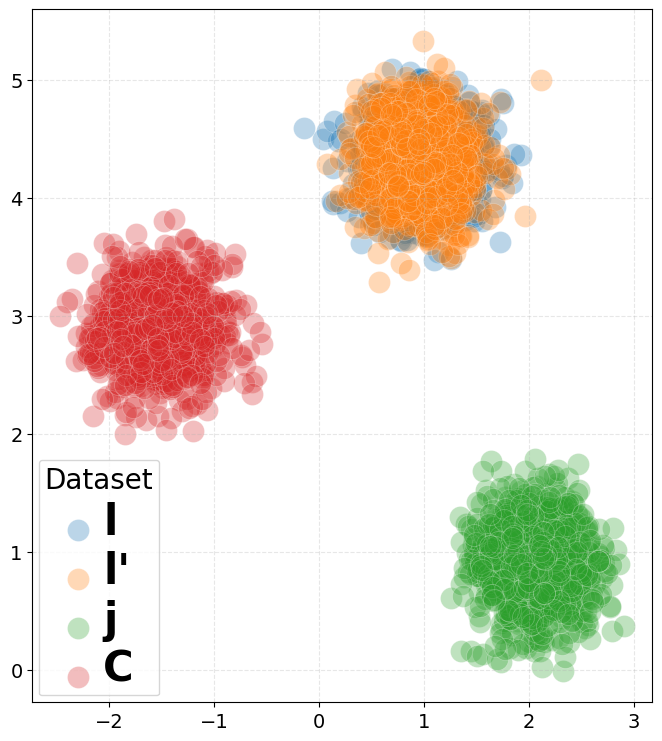

In [9]:
# Define category labels
cm = ["l", "l'", 'j', "C"]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 9)) 

# Scatter plot for each category
for i, label in enumerate(cm):
    x = X[idx_party == i]
    scatter = ax.scatter(
        x[:, 0], 
        x[:, 1], 
        label=label, 
        alpha=0.3, 
        edgecolors='w',  # Changed to 'w' (white) for better visibility
        s=250,           # Size of the markers
        linewidth=0.5,    # Border width of the markers
        # markersize=20
        
    )

# Add legend with customized font size
legend = ax.legend(loc='best', fontsize=23, title='Dataset',prop={'weight':'bold'}, title_fontsize=30)

# Customize legend title font size
for text in legend.get_texts():
    text.set_fontsize(30)  # Legend labels font size

# Customize legend title separately if needed
legend.get_title().set_fontsize(20)  # Legend title font size

# Customize tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=14)

# Optional: Add grid for better visualization
ax.grid(True, linestyle='--', alpha=0.3)

# Save the figure with high resolution
plt.savefig("circle.png", format="pdf", bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [9]:
DS_X_train = torch.tensor(X)
DS_Y_train = torch.tensor(y_true)
idx_party = torch.tensor(idx_party)
n_parties = len(np.unique(idx_party))
#
dataset = []
for ip in np.unique(idx_party):
    i_dataset = My_Single_Dataset(torch.tensor(X[idx_party == ip]), 
                               torch.tensor(y_true[idx_party == ip]))
    dataset.append(i_dataset)

## MDS n = 2

In [40]:

label_distance = label_DS_sw_distance(dataset)
embedding = MDS_emb(label_distance, output_dim=2)
mapping_label = torch.tensor(embedding)

n_projections = 100
nfts = dataset[0].data.shape[1] + mapping_label.shape[1]
projs = torch.tensor(ot.sliced.get_random_projections(nfts, n_projections)).to(torch.float64)

#
def transfrom_ds_projs(ids, mapping_label, projs):
    return transform_ds(ids, mapping_label) @ projs

new_ds = [ transfrom_ds_projs(i, mapping_label, projs) for i in dataset ]

In [41]:
# l, l', j, C
# Cl
# Cl'
# Cj
coalitions = torch.tensor([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0, 0, 0, 1], [1,0,0, 1], [0,1,0,1], [0,0,1,1]]) 
args= argparse.Namespace
args.noise = 0.01
args.lengthscale = 3
args.learning_rate = 0.01
args.training_interation = 50
args.device_ids = [0,1,2,3]
args.chunk_size = 10
args.p = 1
args.n_jobs = 4

In [42]:
i_kernel = Exponential_SW_Kernel(new_ds, args)
A = i_kernel.forward(coalitions, coalitions)

pdf_d = pd.DataFrame(A.cpu().detach().numpy(), columns=["l", "l'", "j", "C", "C$\cup$l", "C$\cup$l'", "C$\cup$j"], index=["l", "l'", "j", "C", "C$\cup$l", "C$\cup$l'", "C$\cup$j"])
# pdf_d

In [48]:
pdf_d

,l,l',j,C,C$\cup$l,C$\cup$l',C$\cup$j
l,1.000000,0.975945,0.035138,0.046811,0.216358,0.217650,0.046559
l',0.975945,1.000000,0.035331,0.046226,0.213632,0.215002,0.046267
j,0.035138,0.035331,1.000000,0.013493,0.023968,0.024043,0.116161
C,0.046811,0.046226,0.013493,1.000000,0.216358,0.215002,0.116161
C$\cup$l,0.216358,0.213632,0.023968,0.216358,1.000000,0.987899,0.187452
C$\cup$l',0.217650,0.215002,0.024043,0.215002,0.987899,1.000000,0.187964
C$\cup$j,0.046559,0.046267,0.116161,0.116161,0.187452,0.187964,1.000000


In [44]:
%matplotlib inline

In [47]:
import seaborn as sns
%matplotlib inline
# import matplotlib.pyplot as plt
# # ax = plt.axes(f)
# fig, ax = plt.subplots(figsize=(12, 12))  # Width=12 inches, Height=8 inches
# sns.heatmap(pdf_d, annot=True, ax=ax, cmap="Blues", fmt=".4f",annot_kws={"size": 20})

# plt.show()
# plt.savefig("heat_map_moon_1.png", format="png", bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>

In [67]:
def plot_heatmap(pdf, file_name="heat_map.png", fmt="pdf"):
    def format_annotation(x):
        return "1" if x == 1 else f"{x:.2f}"

    # Vectorize the function to apply it to the entire array
    vectorized_format = np.vectorize(format_annotation)
    annot = vectorized_format(pdf)
    
    fig, ax = plt.subplots(figsize=(12, 9))  # Width=12 inches, Height=8 inches
    # plt.rc('font', weight='bold')

    # Create the heatmap
    heatmap = sns.heatmap(
        pdf,
        annot=annot,           # Use the custom annotations
        fmt="",                # Disable default formatting
        ax=ax,
        cmap="Blues",
        annot_kws={"size": 27, #25
                   "weight": "bold"
                  },# Annotation text size
        linewidths=0.5,        # Width of the lines between cells
        linecolor='white',     # Color of the lines between cells
        cbar=True,             # Show the colorbar
        cbar_kws={
            'shrink': 0.8,     # Shrink the colorbar to make space for the title
            'aspect': 30       # Aspect ratio of the colorbar
        }
    )
    
    # Set the colorbar title and adjust its font size
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_label('Value', fontsize=20)  # Set label and font size
    font_dict = {'fontsize': 33, 'fontweight': 'bold'}
    plt.setp(ax.get_xticklabels(), **font_dict)
    plt.setp(ax.get_yticklabels(), **font_dict)
   
    colorbar.ax.tick_params(labelsize=25)  # Adjusts the colorbar tick labels
    
    # Display the plot
    plt.tight_layout()  # Adjusts subplot params for a neat layout
    
    plt.savefig(file_name, format=fmt, bbox_inches='tight', dpi=300)
    plt.show()
        

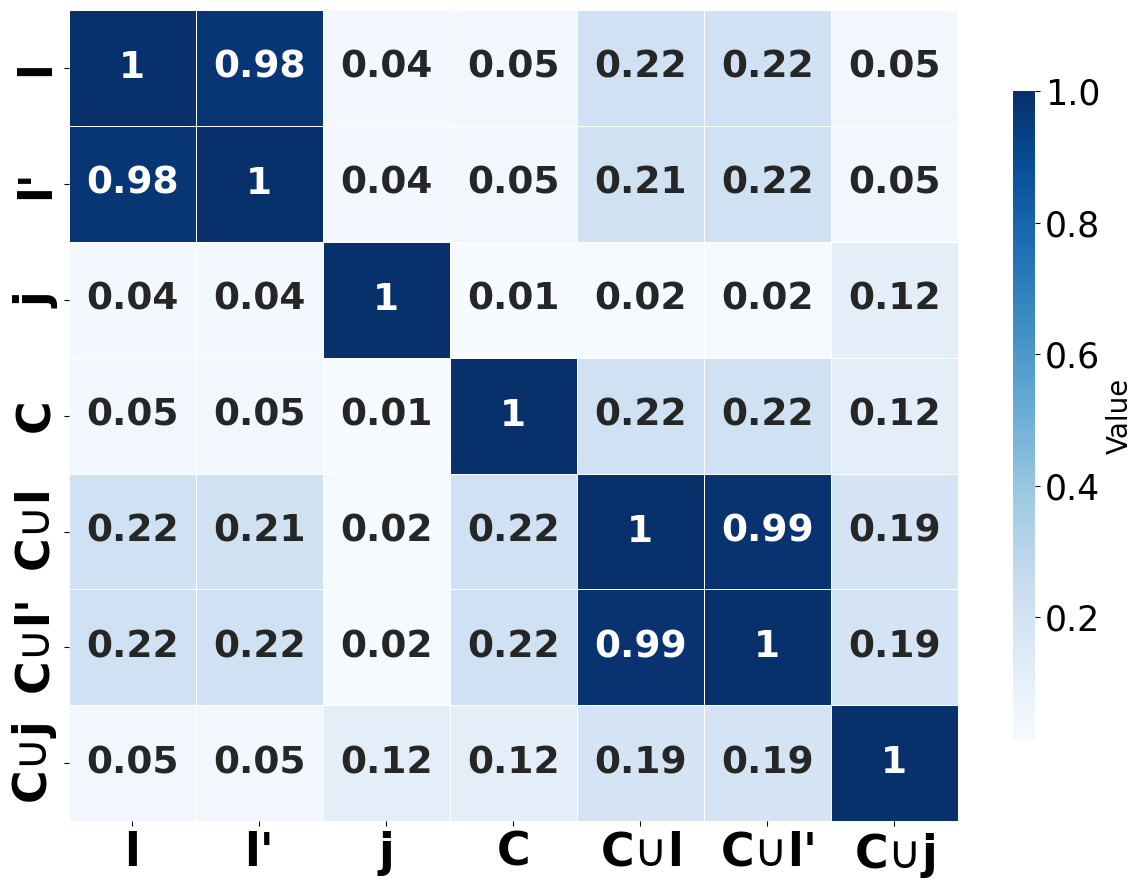

In [68]:
plot_heatmap(pdf_d, "MDS_2_heatmap.png")

## n = 1

In [8]:
label_distance = label_DS_sw_distance(dataset)
embedding = MDS_emb(label_distance, output_dim=1)
mapping_label = torch.tensor(embedding)
#
n_projections = 50
nfts = dataset[0].data.shape[1] + mapping_label.shape[1]
projs = torch.tensor(ot.sliced.get_random_projections(nfts, n_projections)).to(torch.float64)

#
def transfrom_ds_projs(ids, mapping_label, projs):
    return transform_ds(ids, mapping_label) @ projs

new_ds1 = [ transfrom_ds_projs(i, mapping_label, projs) for i in dataset ]

i1_kernel = Exponential_SW_Kernel(new_ds1, args)
A = i1_kernel.forward(coalitions, coalitions)

pdf_d = pd.DataFrame(A.cpu().detach().numpy(), columns=["l", "l'", "j", "C", "C$\cup$l", "C$\cup$l'", "C U j"], index=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"])
# pdf_d
plot_heatmap(pdf_d, "circle_MDS_1_heatmap.png")

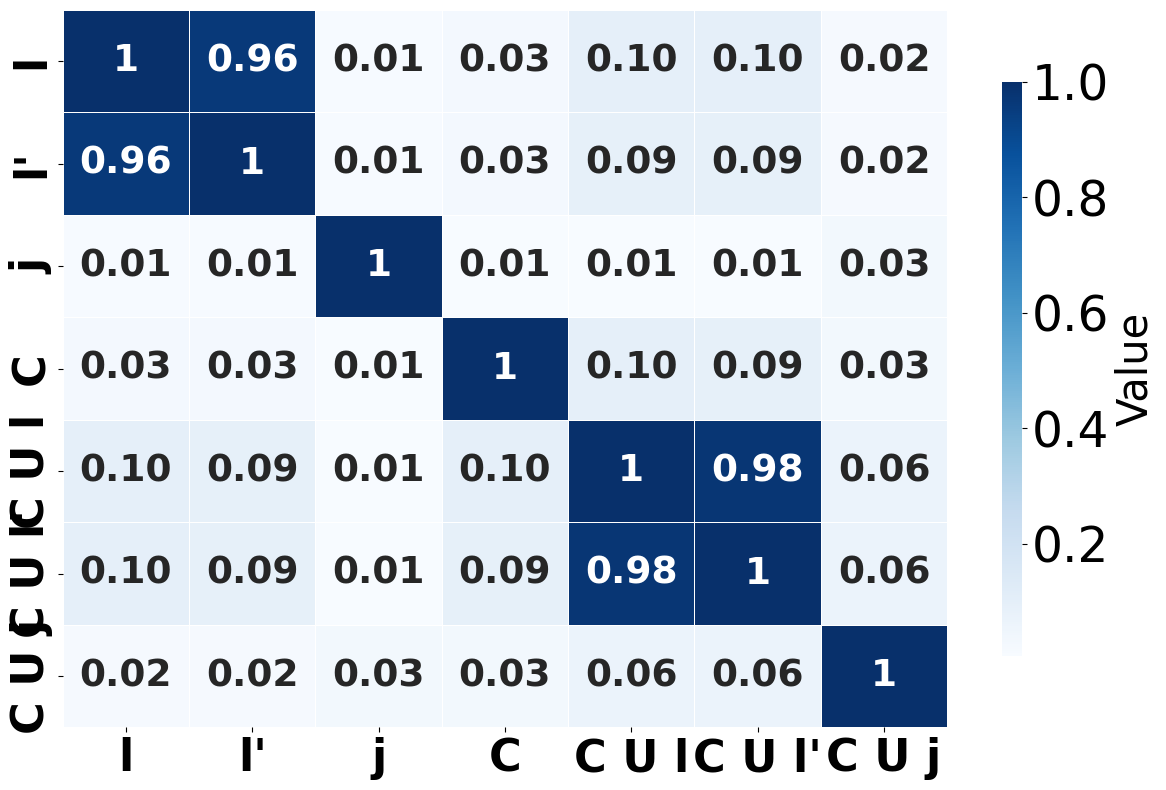

In [34]:

label_distance = label_DS_sw_distance(dataset)
embedding = MDS_emb(label_distance, output_dim=2)
mapping_label = torch.tensor(embedding)

n_projections = 100
nfts = dataset[0].data.shape[1] + mapping_label.shape[1]
projs = torch.tensor(ot.sliced.get_random_projections(nfts, n_projections)).to(torch.float64)

#
def transfrom_ds_projs(ids, mapping_label, projs):
    return transform_ds(ids, mapping_label) @ projs

new_ds = [ transfrom_ds_projs(i, mapping_label, projs) for i in dataset ]

#
def transfrom_ds_projs(ids, mapping_label, projs):
    return transform_ds(ids, mapping_label) @ projs

new_ds1 = [ transfrom_ds_projs(i, mapping_label, projs) for i in dataset ]

i1_kernel = Exponential_SW_Kernel(new_ds1, args)
A = i1_kernel.forward(coalitions, coalitions)

pdf_d = pd.DataFrame(A.cpu().detach().numpy(), columns=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"], index=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"])
# pdf_d
plot_heatmap(pdf_d, "circle_MDS_2_heatmap.png")

## n = 4

/home/nguyenpk/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


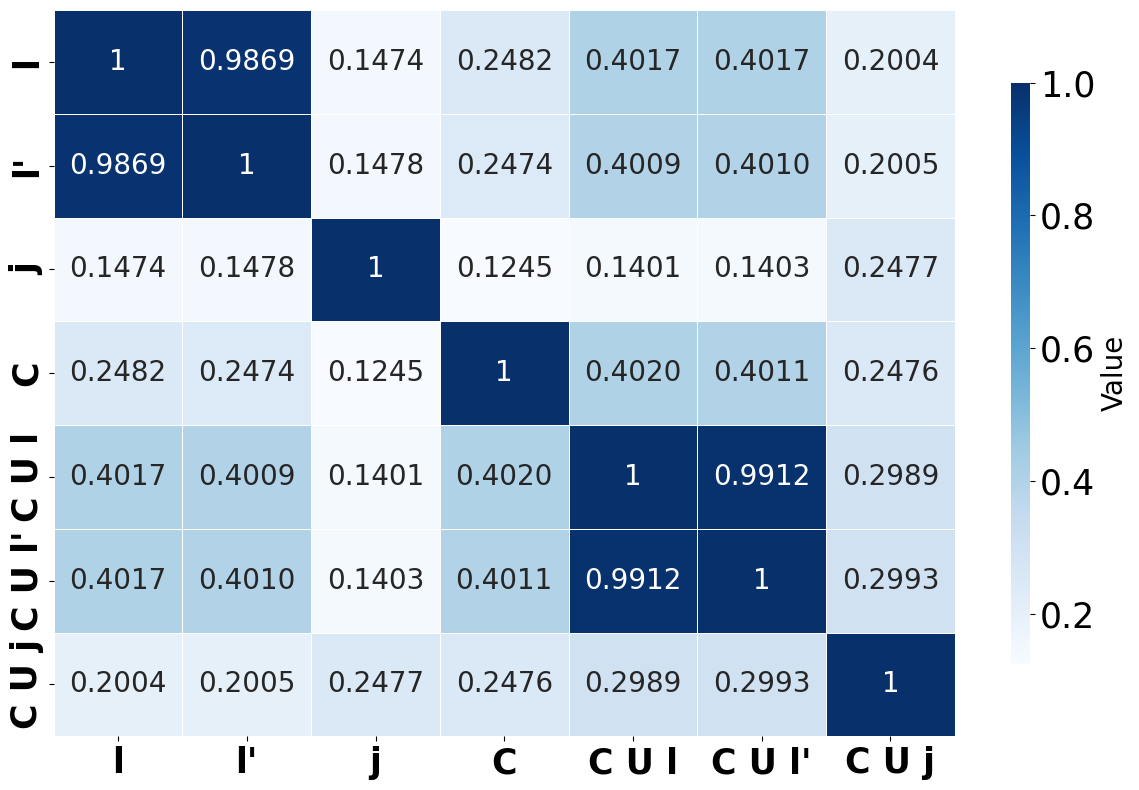

In [113]:
label_distance = label_DS_sw_distance(dataset)
embedding = MDS_emb(label_distance, output_dim=4)
mapping_label = torch.tensor(embedding)

n_projections = 100
nfts = dataset[0].data.shape[1] + mapping_label.shape[1]
projs = torch.tensor(ot.sliced.get_random_projections(nfts, n_projections)).to(torch.float64)

#
def transfrom_ds_projs(ids, mapping_label, projs):
    return transform_ds(ids, mapping_label) @ projs

new_ds = [ transfrom_ds_projs(i, mapping_label, projs) for i in dataset ]

i_kernel = Exponential_SW_Kernel(new_ds, args)
A = i_kernel.forward(coalitions, coalitions)

pdf_d = pd.DataFrame(A.cpu().detach().numpy(), columns=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"], index=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"])
# pdf_d
plot_heatmap(pdf_d, "circle_MDS_4_heatmap.png")

## MAPPING ONE HOT

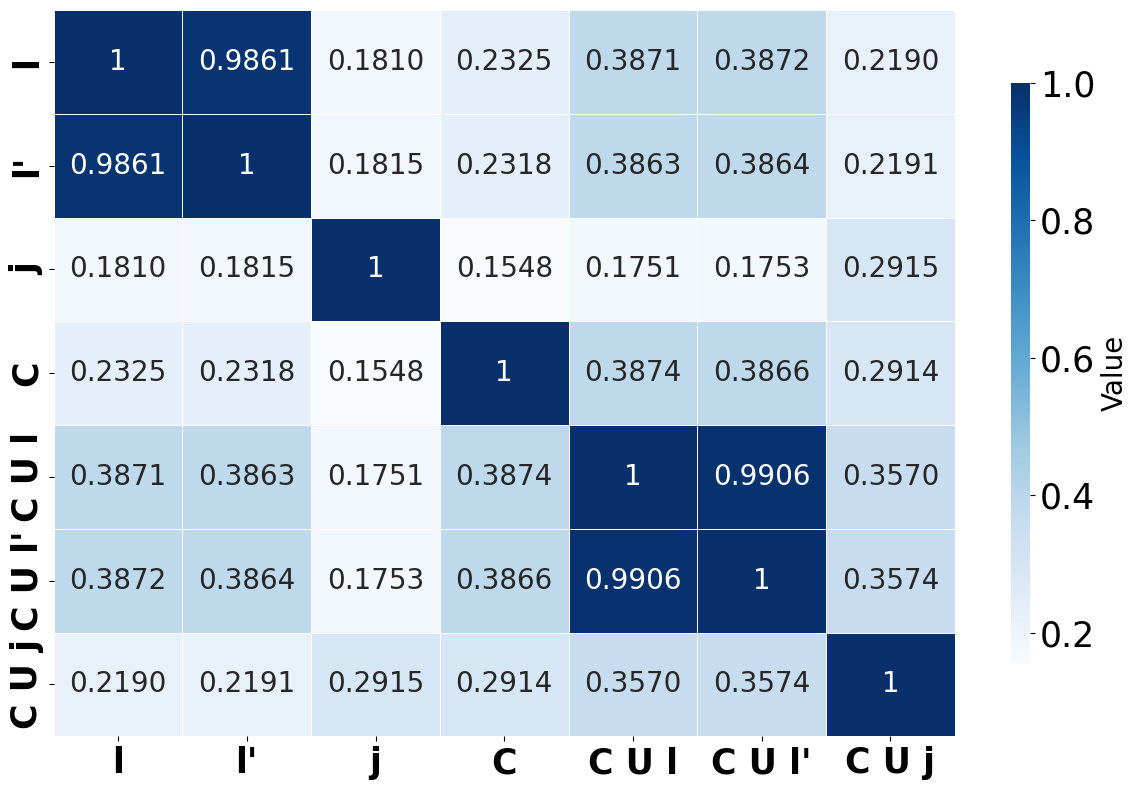

In [114]:
import numpy as np

# Find the unique categories and their inverse indices
categories, inverse = np.unique(y_true, return_inverse=True)
_,inverse = np.unique(categories, return_inverse=True)


# Create the one-hot encoded matrix
mapping_one_hot = np.zeros((categories.size, categories.size))
mapping_one_hot[np.arange(categories.size), inverse] = 1

# mapping:

n_projections = 100
nfts = dataset[0].data.shape[1] + mapping_one_hot.shape[1]
projs = torch.tensor(ot.sliced.get_random_projections(nfts, n_projections)).to(torch.float64)

#
def transfrom_ds_projs(ids, mapping_label, projs):
    return transform_ds(ids, mapping_label) @ projs

new_ds = [ transfrom_ds_projs(i, mapping_one_hot, projs) for i in dataset ]

i_kernel = Exponential_SW_Kernel(new_ds, args)
A = i_kernel.forward(coalitions, coalitions)

pdf_d = pd.DataFrame(A.cpu().detach().numpy(), columns=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"], index=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"])
# pdf_d
plot_heatmap(pdf_d, "circle_MDS_1hot_heatmap.png")

## NO Y


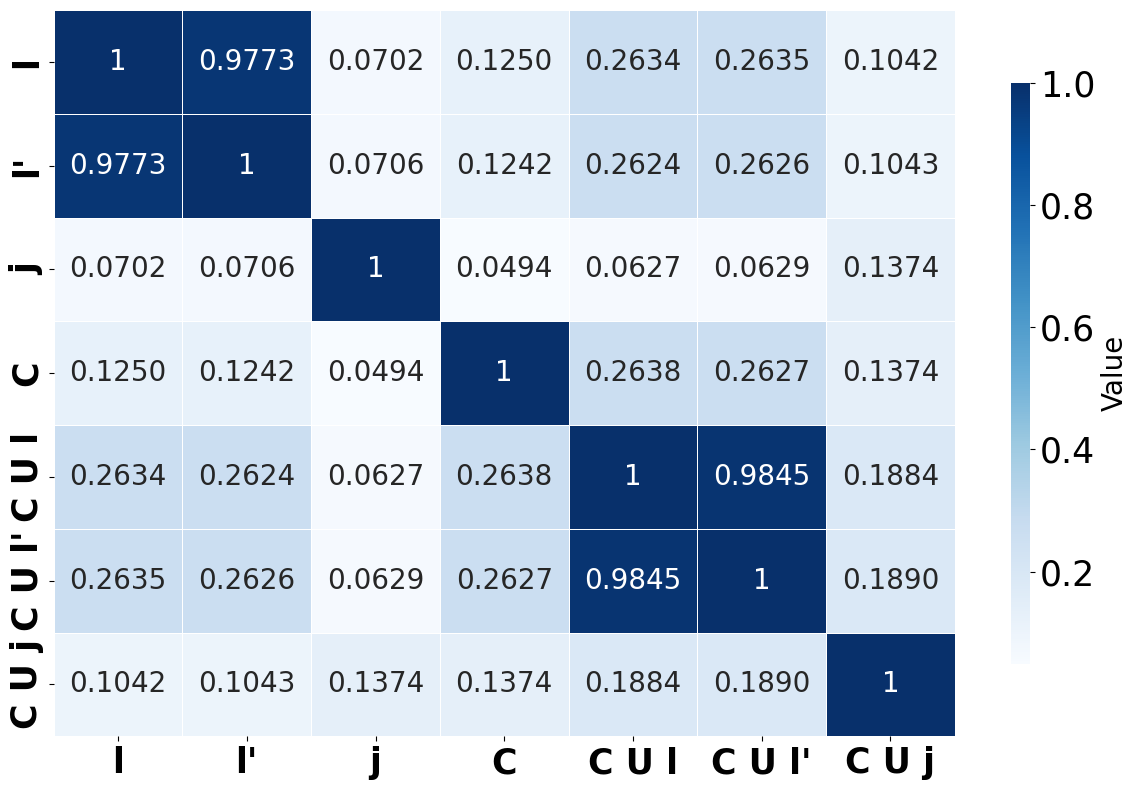

In [115]:
import numpy as np

mapping_label = None
# mapping:

n_projections = 100
nfts = dataset[0].data.shape[1] 
projs = torch.tensor(ot.sliced.get_random_projections(nfts, n_projections)).to(torch.float64)

#
def transfrom_ds_projs(ids, mapping_label, projs):
    return transform_ds(ids, mapping_label) @ projs

new_ds = [ transfrom_ds_projs(i, mapping_label, projs) for i in dataset ]

i_kernel = Exponential_SW_Kernel(new_ds, args)
A = i_kernel.forward(coalitions, coalitions)

pdf_d = pd.DataFrame(A.cpu().detach().numpy(), columns=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"], index=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"])
# pdf_d
plot_heatmap(pdf_d, "circle_MDS_X_heatmap.png")

## y



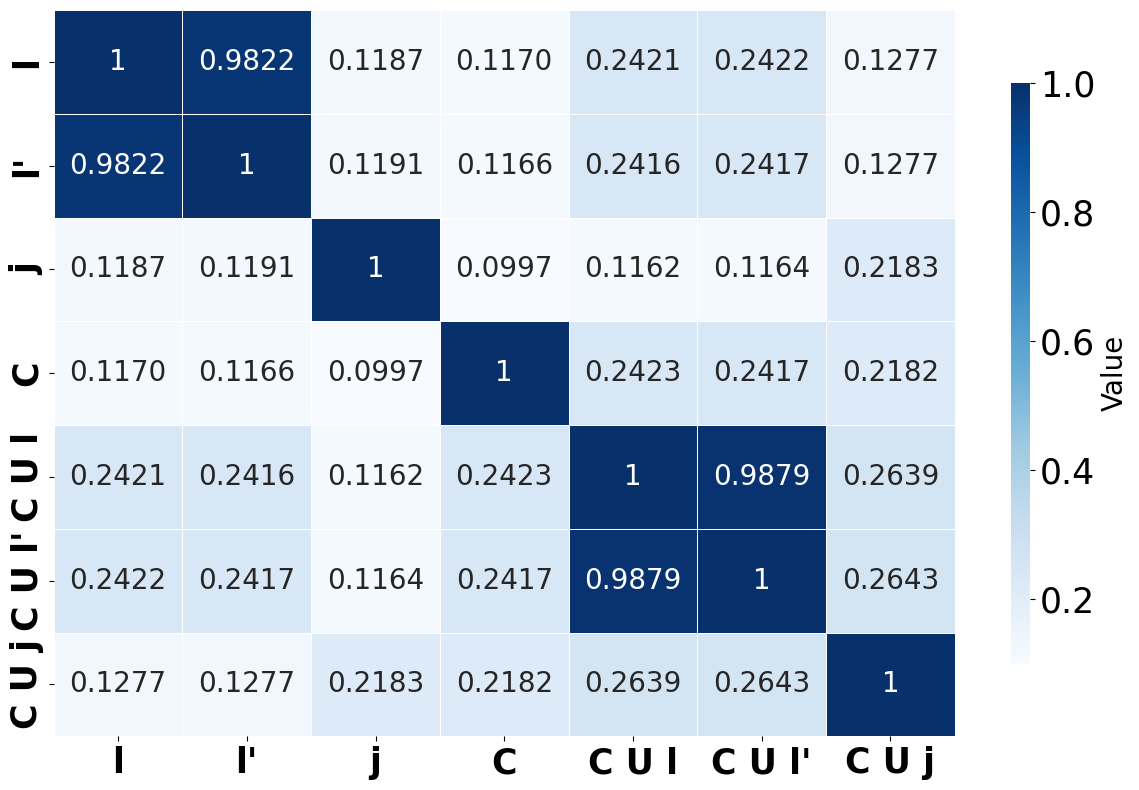

In [116]:
import numpy as np

mapping_= np.unique(y_true).reshape(-1,1)


n_projections = 100
nfts = dataset[0].data.shape[1] + mapping_.shape[1]
projs = torch.tensor(ot.sliced.get_random_projections(nfts, n_projections)).to(torch.float64)

#
def transfrom_ds_projs(ids, mapping_label, projs):
    return transform_ds(ids, mapping_label) @ projs

new_ds = [ transfrom_ds_projs(i, mapping_, projs) for i in dataset ]

i_kernel = Exponential_SW_Kernel(new_ds, args)
A = i_kernel.forward(coalitions, coalitions)

pdf_d = pd.DataFrame(A.cpu().detach().numpy(), columns=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"], index=["l", "l'", "j", "C", "C U l", "C U l'", "C U j"])
# pdf_d
plot_heatmap(pdf_d, "circle_MDS_Xy_heatmap.png")
